<a href="https://colab.research.google.com/github/eyaler/face_toolbox_keras/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone https://github.com/eyaler/face_toolbox_keras.git
%cd face_toolbox_keras

/content
Cloning into 'face_toolbox_keras'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 305 (delta 59), reused 67 (delta 55), pack-reused 221
Receiving objects: 100% (305/305), 250.04 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (43/43), done.
/content/face_toolbox_keras


In [2]:
!gdown https://drive.google.com/uc?id=1H37LER8mRRI4q_nxpS3uQz3DcGHkTrNU
!mv lresnet100e_ir_keras.h5 ./models/verifier/insightface/lresnet100e_ir_keras.h5
!gdown https://drive.google.com/uc?id=18MyyXQIwhR5I6gzipYMiJ9ywgvFWQMvI
!mv backbone_ir50_ms1m_keras.h5 ./models/verifier/face_evoLVe_ir50/backbone_ir50_ms1m_keras.h5
!gdown https://drive.google.com/uc?id=1P_eQHU8bNJEsB6hHt_fnltOwQVKIfhiX
!mv backbone_ir50_asia_keras.h5 ./models/verifier/face_evoLVe_ir50/backbone_ir50_asia_keras.h5

Downloading...
From: https://drive.google.com/uc?id=1H37LER8mRRI4q_nxpS3uQz3DcGHkTrNU
To: /content/face_toolbox_keras/lresnet100e_ir_keras.h5
100% 262M/262M [00:01<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=18MyyXQIwhR5I6gzipYMiJ9ywgvFWQMvI
To: /content/face_toolbox_keras/backbone_ir50_ms1m_keras.h5
100% 175M/175M [00:00<00:00, 187MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_eQHU8bNJEsB6hHt_fnltOwQVKIfhiX
To: /content/face_toolbox_keras/backbone_ir50_asia_keras.h5
100% 175M/175M [00:00<00:00, 207MB/s]


In [3]:
!pip install keras==2.2.4
%tensorflow_version 1.x
!pip install h5py==2.10.0

     |████████████████████████████████| 312 kB 5.4 MB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.4 which is incompatible.
TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

---

In [6]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

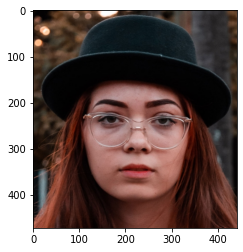

In [7]:
# Test images are obtained on https://www.pexels.com/
im = cv2.imread("images/test.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

---
# 0. Coordinate ordering

The coordinate in this demo has ordering `(x, y)`, which follows the format fo numpy array: `x` is the vertical axis and `y` the horizontal axis.

---
# 1. Face detection

Face deteciton using S3FD and FAN.

In [8]:
from models.detector import face_detector

Using TensorFlow backend.


In [9]:
fd = face_detector.FaceAlignmentDetector(
    lmd_weights_path="./models/detector/FAN/2DFAN-4_keras.h5"# 2DFAN-4_keras.h5, 2DFAN-1_keras.h5
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'conv3_3_norm/conv3_3_norm_gamma:0' shape=(256,) dtype=float32> gamma
tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma
tracking <tf.Variable 'conv5_3_norm/conv5_3_norm_gamma:0' shape=(512,) dtype=float32> gamma


## Detect faces

In [10]:
bboxes = fd.detect_face(im, with_landmarks=False)

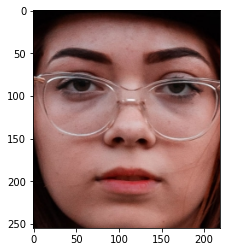

In [11]:
assert len(bboxes) > 0, "No face detected."

# Display detected face
x0, y0, x1, y1, score = bboxes[0] # show the first detected face
x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

plt.imshow(im[x0:x1, y0:y1, :])

## Detect faces and landmarks

`FaceDetector` will instantiate `FANLandmarksDetector` when calling `detect_face(with_landmarks=True)` the first time.

In [12]:
bboxes, landmarks = fd.detect_face(im, with_landmarks=True)

Building FAN for landmarks detection...
Done.


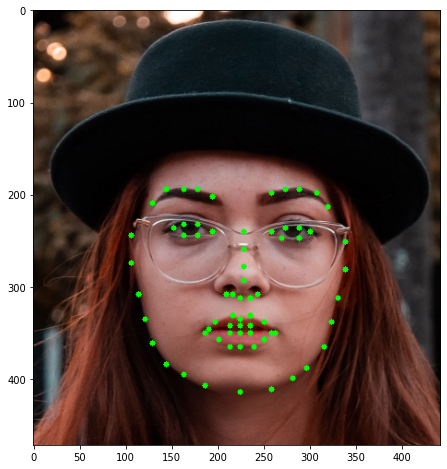

In [13]:
# Display landmarks
plt.figure(figsize=(15,8))
num_faces = len(bboxes)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(fd.draw_landmarks(im, landmarks[i], color=(0,255,0)))
    except:
        pass

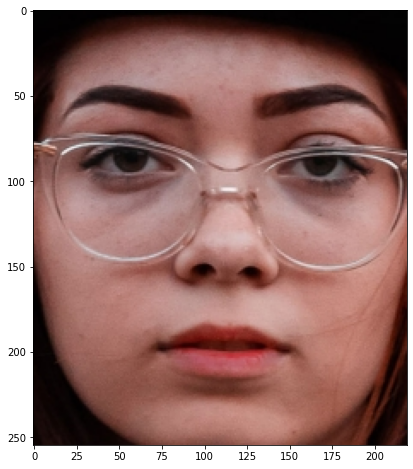

In [14]:
plt.figure(figsize=(15,8))
num_faces = len(bboxes)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        x0, y0, x1, y1, score = bboxes[i] 
        x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
        
        plt.imshow(im[x0:x1, y0:y1, :])
        plt.imsave(f'{i}.jpg')
    except:
        pass

---
# 2. Face parsing

Face parsing using BiSeNet.

In [15]:
from models.parser import face_parser

In [16]:
prs = face_parser.FaceParser()

## Parse without deteciton

In [18]:
out, faces = prs.parse_face(im, get_faces=True)

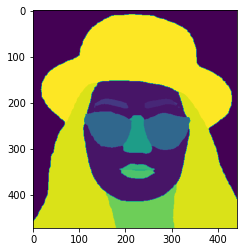

In [19]:
plt.imshow(out[0])

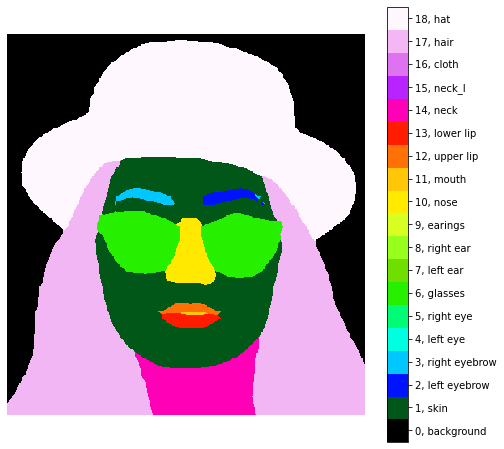

In [20]:
# Show parsing result with annotations

from utils.visualize import show_parsing_with_annos
show_parsing_with_annos(out[0])

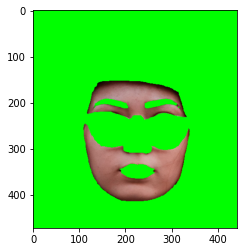

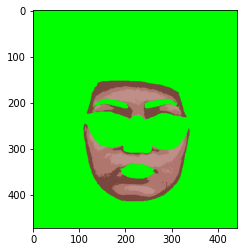

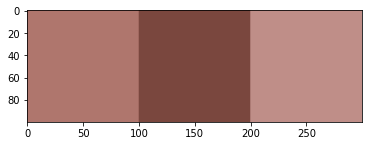

[((175, 118, 109), 11822, 0.381), ((122, 71, 62), 11494, 0.371), ((191, 142, 136), 7689, 0.248)]


In [21]:
# Skin color:

num_colors =  3#@param {type: "integer"}
min_color_frac = 0.05 #@param {type: "slider", step:0.01, max:1}

skin = np.where(out[0][..., None] == 1, faces[0], (0,255,0)).astype(np.uint8)
plt.imshow(skin)
plt.show()

from PIL import Image
skin = Image.fromarray(skin)
colors = skin.quantize(colors=num_colors+1).convert('RGB')
plt.imshow(colors)
plt.show()
colors = colors.getcolors()
colors = sorted([color for color in colors if color[1] != (0,255,0)], reverse=True)
s = sum(color[0] for color in colors)
colors = [(color[1], color[0], round(color[0]/s, 3)) for color in colors if color[0] >= s*min_color_frac]
color_img = np.hstack([np.ones(shape=(100, 100, 3))*np.array(color[0]) for color in colors]).astype(np.uint8)
plt.imshow(color_img)
plt.show()
print(colors)


## Parse with detection

Parsing network has its best performance on single face (even better if aligned).

Resize image to (768, 768).


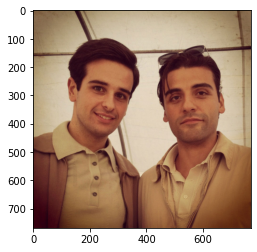

In [22]:
im = cv2.imread("images/test2.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [23]:
# Set detector into FaceParser
try:
    fd
except:
    from detector import face_detector
    fd = face_detector.FaceAlignmentDetector()
    
prs.set_detector(fd)
# prs.remove_detector()

In [24]:
outs, faces = prs.parse_face(im, with_detection=True, get_faces=True)

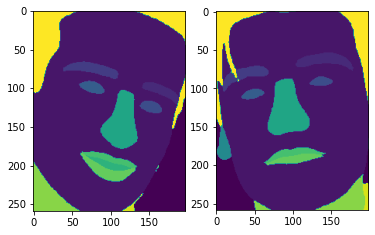

In [25]:
#plt.figure(figsize=(15,8))
num_faces = len(outs)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(outs[i])
    except:
        pass

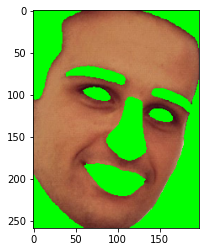

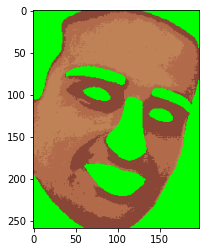

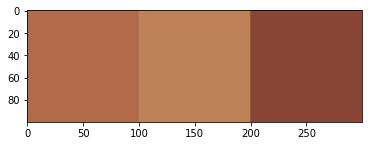

[((177, 107, 74), 12479, 0.364), ((191, 129, 86), 11226, 0.327), ((137, 69, 53), 10586, 0.309)]


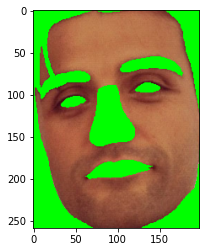

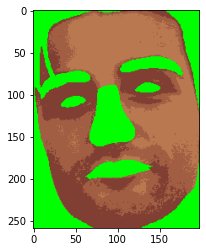

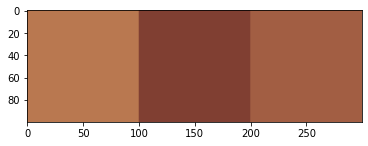

[((185, 120, 80), 12927, 0.354), ((128, 63, 50), 11957, 0.327), ((162, 94, 67), 11678, 0.319)]


In [26]:
# Skin color:

num_colors =  3#@param {type: "integer"}
min_color_frac = 0.05 #@param {type: "slider", step:0.01, max:1}

for out, face in zip(outs, faces):
  skin = np.where(out[..., None] == 1, face, (0,255,0)).astype(np.uint8)
  plt.imshow(skin)
  plt.show()

  skin = Image.fromarray(skin)
  colors = skin.quantize(colors=num_colors+1).convert('RGB')
  plt.imshow(colors)
  plt.show()
  colors = colors.getcolors()
  colors = sorted([color for color in colors if color[1] != (0,255,0)], reverse=True)
  s = sum(color[0] for color in colors)
  colors = [(color[1], color[0], round(color[0]/s, 3)) for color in colors if color[0] >= s*min_color_frac]
  color_img = np.hstack([np.ones(shape=(100, 100, 3))*np.array(color[0]) for color in colors]).astype(np.uint8)
  plt.imshow(color_img)
  plt.show()
  print(colors)


---
# 3. Detect irises

Iris detection using ELG (Eye region Landmarks based Gaze estimation).

In [27]:
from models.detector.iris_detector import IrisDetector

## Detect iris, eyelibs and pulpils

Resize image to (512, 768).


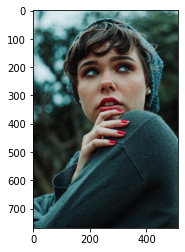

In [28]:
im = cv2.imread("images/test5.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [29]:
idet = IrisDetector()

In [30]:
idet.set_detector(fd)

In [31]:
eye_lms = idet.detect_iris(im)

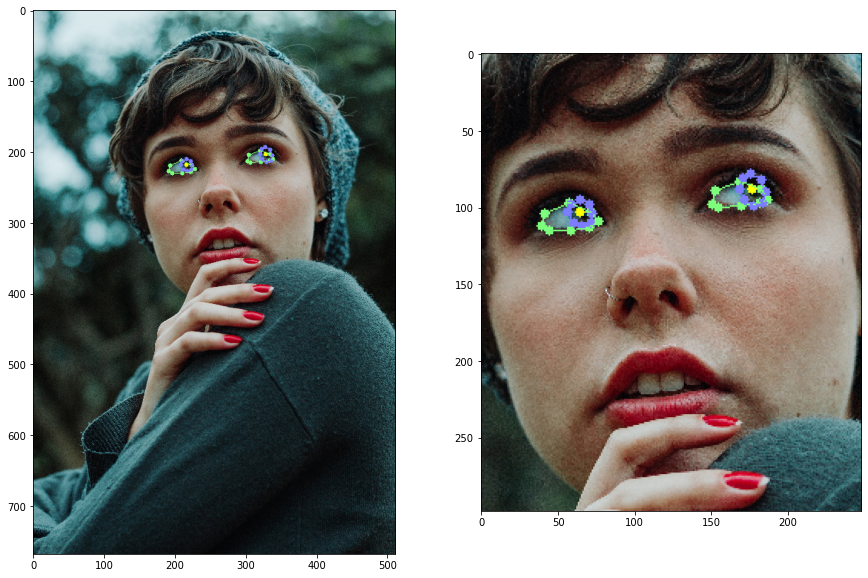

In [32]:
# Display detection result
plt.figure(figsize=(15,10))
draw = idet.draw_pupil(im, eye_lms[0][0,...]) # draw left eye
draw = idet.draw_pupil(draw, eye_lms[0][1,...]) # draw right eye
bboxes = fd.detect_face(im, with_landmarks=False)
x0, y0, x1, y1, _ = bboxes[0].astype(np.int32)
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(draw[x0:x1, y0:y1])

---
# 4. Face verification

Face verification using facenet.

In [33]:
from models.verifier.face_verifier import FaceVerifier

In [34]:
im1 = cv2.imread("images/test0.jpg")[..., ::-1]
im1 = resize_image(im1) # Resize image to prevent GPU OOM.
im2 = cv2.imread("images/BO1.jpg")[..., ::-1]
im2 = resize_image(im2) # Resize image to prevent GPU OOM.
im3 = cv2.imread("images/DT.jpg")[..., ::-1]
im3 = resize_image(im3) # Resize image to prevent GPU OOM.

In [35]:
fv = FaceVerifier(classes=512, extractor="facenet") # extractor="insightface"

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [36]:
fv.set_detector(fd)

## Verify if two given faces are the same person

In [37]:
# Face verification
result1, distance1 = fv.verify(im1, im2, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)
result2, distance2 = fv.verify(im1, im3, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)

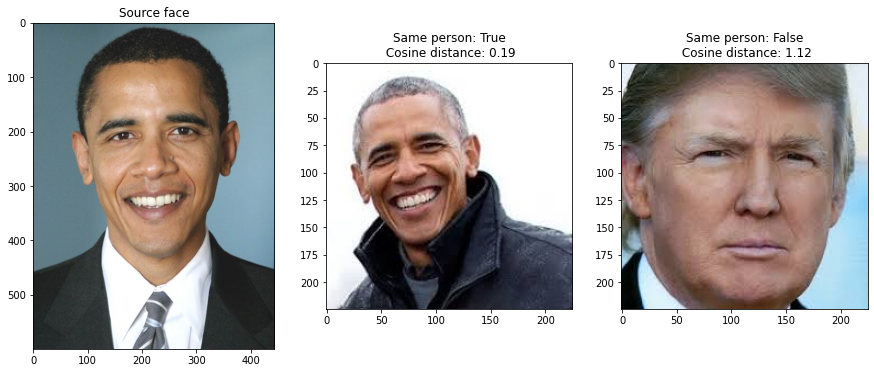

In [38]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title(f"Source face")
plt.imshow(im1)
plt.subplot(1,3,2)
plt.title(f"Same person: {str(result1)}\n Cosine distance: {str(round(distance1, 2))}")
plt.imshow(im2)
plt.subplot(1,3,3)
plt.title(f"Same person: {str(result2)}\n Cosine distance: {str(round(distance2, 2))}")
plt.imshow(im3)

---
# 5. Gender and Age Estimation

Gender/Age estimation using insightface mobilenet.

In [39]:
from models.estimator.gender_age_estimator import GenderAgeEstimator

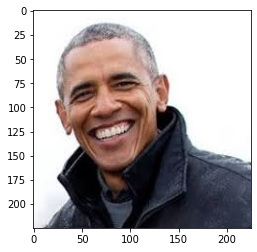

In [40]:
im = cv2.imread("images/BO1.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [41]:
gae = GenderAgeEstimator(model_type="insightface")

In [42]:
gae.set_detector(fd)

In [43]:
gender, age = gae.predict_gender_age(im, with_detection=True)

In [44]:
print("Gender: female") if gender == 0 else print("Gender: male")
print(f"Age: {str(age)}")

Gender: male
Age: 57
